<a href="https://colab.research.google.com/github/maskot1977/PythonCourse2019/blob/master/hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
f = lambda x: 1/(1 + np.exp(-x)) + 0.1 * np.sin(4 * x) # ノイズ入り
g = lambda x: 1/(1 + np.exp(-x)) # ノイズなし

In [2]:
X = np.linspace(-10, 10, 21)
Y = f(X)

X = np.array(X).reshape(len(X), 1)
Y = np.reshape(Y,(-1))

x_latent = np.linspace(-20, 20, 200)
y_latent = g(x_latent)

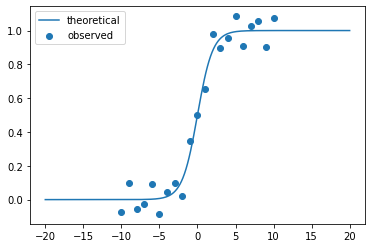

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(X, Y, label="observed")
plt.plot(x_latent, y_latent, label="theoretical")
plt.legend()
plt.show()

In [4]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(), SVR())
model.fit(X, Y)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma='scale', kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

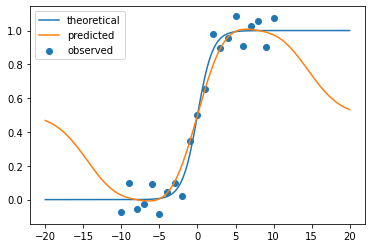

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(x_latent, y_latent, label="theoretical")
plt.scatter(X, Y, label="observed")
plt.plot(
    x_latent,
    model.predict(x_latent.reshape(-1, 1)),
    label="predicted"
)
plt.legend()
plt.show()

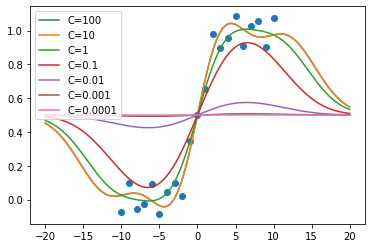

In [6]:
plt.scatter(X, Y)
for c in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    model = make_pipeline(StandardScaler(), SVR(C=c))
    model.fit(X, Y)
    y_predict = model.predict(x_latent.reshape(len(x_latent), 1))
    plt.plot(x_latent, y_predict, label="C=" + str(c))
plt.legend()
plt.show()

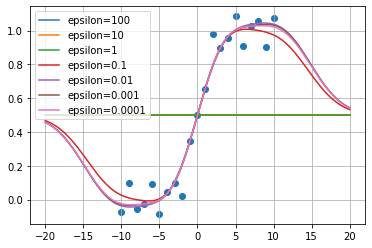

In [7]:
plt.scatter(X, Y)
for e in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    model = make_pipeline(StandardScaler(), SVR(epsilon=e))
    model.fit(X, Y)
    y_predict = model.predict(x_latent.reshape(len(x_latent), 1))
    plt.plot(x_latent, y_predict, label="epsilon=" + str(e))
plt.legend()
plt.grid()
plt.show()

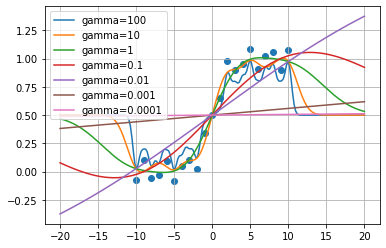

In [8]:
plt.scatter(X, Y)
for g in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    model = make_pipeline(StandardScaler(), SVR(gamma=g))
    model.fit(X, Y)
    y_predict = model.predict(x_latent.reshape(len(x_latent), 1))
    plt.plot(x_latent, y_predict, label="gamma=" + str(g))
plt.legend()
plt.grid()
plt.show()

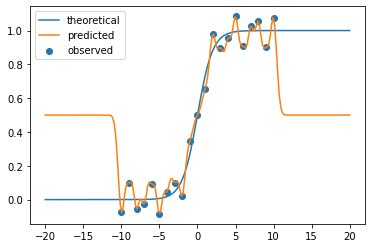

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.0001,
                     gamma=100, kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [9]:
best_score = 0
best_model = False
for c in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    for e in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
        for g in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
            model = make_pipeline(
                StandardScaler(), 
                SVR(C=c, epsilon=e, gamma=g)
                )
            model.fit(X, Y)
            score = model.score(X, Y)
            if best_score < score:
                best_score = score
                best_model = model

x_latent = np.linspace(-20, 20, 200)
y_predict = best_model.predict(x_latent.reshape(len(x_latent), 1))
plt.scatter(X, Y, label="observed")
plt.plot(x_latent, y_latent, label="theoretical")
plt.plot(x_latent, y_predict, label="predicted")
plt.legend()
plt.show()
best_model

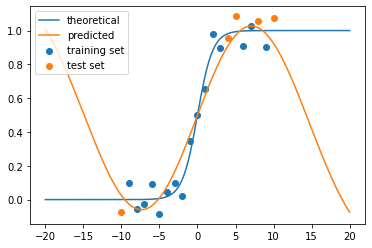

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.0001,
                     gamma=0.1, kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

best_score = 0
best_model = False
for c in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    for e in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
        for g in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
            model = make_pipeline(
                StandardScaler(), 
                SVR(C=c, epsilon=e, gamma=g)
                )
            model.fit(X_train, y_train)
            score = model.score(X_test, y_test)
            if best_score < score:
                best_score = score
                best_model = model

x_latent = np.linspace(-20, 20, 200)
y_predict = best_model.predict(x_latent.reshape(len(x_latent), 1))
plt.scatter(X_train, y_train, label="training set")
plt.scatter(X_test, y_test, label="test set")
plt.plot(x_latent, y_latent, label="theoretical")
plt.plot(x_latent, y_predict, label="predicted")
plt.legend()
plt.show()
best_model

In [11]:
!pip install optuna

In [32]:
def objective(trial):
    c = trial.suggest_loguniform('C', 0.00001, 1000)
    e = trial.suggest_loguniform('epsilon', 0.00001, 1000)
    g = trial.suggest_loguniform('gamma', 0.00001, 1000)
    model = make_pipeline(
        StandardScaler(), 
        SVR(C=c, epsilon=e, gamma=g)
    )
    model.fit(X_train, y_train)
    return model.score(X_train, y_train)
    #return model.score(X_test, y_test)
    #return model.score(X, Y)

In [33]:
import optuna
study = optuna.create_study(direction='maximize')

In [34]:
optuna.logging.set_verbosity(optuna.logging.WARN)
study.optimize(objective, n_trials=1000, show_progress_bar=True)

/usr/local/lib/python3.6/dist-packages/optuna/progress_bar.py:47: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



In [35]:
study.best_params

{'C': 1.1994430428541043,
 'epsilon': 3.2180335398605434e-05,
 'gamma': 116.85636586875175}

In [36]:
study.best_value

0.9999999936087346

In [37]:
best_model = make_pipeline(
        StandardScaler(), 
        SVR(**study.best_params)
    )

In [38]:
best_model

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1.1994430428541043, cache_size=200, coef0=0.0, degree=3,
                     epsilon=3.2180335398605434e-05, gamma=116.85636586875175,
                     kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [39]:
best_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1.1994430428541043, cache_size=200, coef0=0.0, degree=3,
                     epsilon=3.2180335398605434e-05, gamma=116.85636586875175,
                     kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

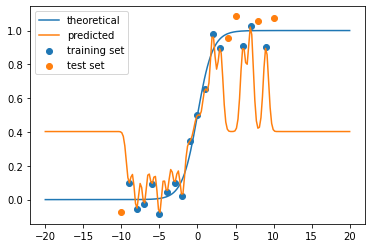

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1.1994430428541043, cache_size=200, coef0=0.0, degree=3,
                     epsilon=3.2180335398605434e-05, gamma=116.85636586875175,
                     kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [40]:
x_latent = np.linspace(-20, 20, 200)
y_predict = best_model.predict(x_latent.reshape(len(x_latent), 1))
plt.scatter(X_train, y_train, label="training set")
plt.scatter(X_test, y_test, label="test set")
plt.plot(x_latent, y_latent, label="theoretical")
plt.plot(x_latent, y_predict, label="predicted")
plt.legend()
plt.show()
best_model

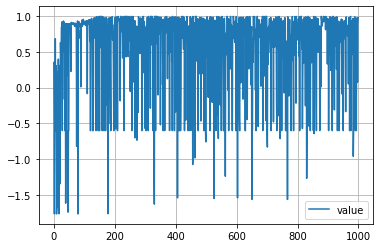

In [21]:
plt.plot([trial.value for trial in study.trials], label='value')
plt.grid()
plt.legend()
plt.show()

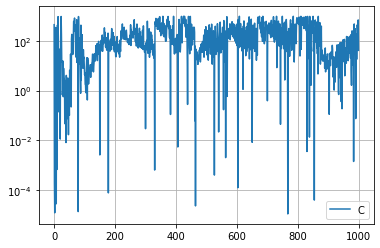

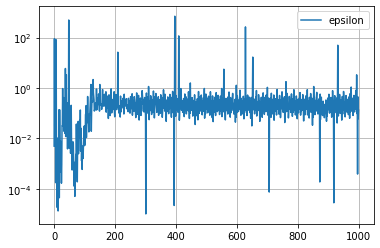

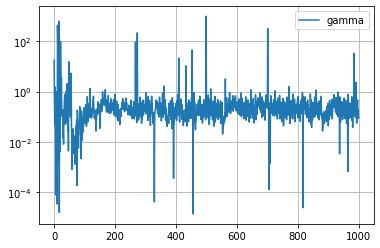

In [22]:
for key in study.trials[0].params.keys():
    plt.plot([trial.params[key] for trial in study.trials], label=key)
    plt.grid()
    plt.yscale('log')
    plt.legend()
    plt.show()